<a href="https://colab.research.google.com/github/yingzibu/a_inhibitor_design/blob/main/examples/experiments/transformer/Transformer_SELFIES_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install rdkit --quiet
! pip install selfies --quiet
! pip install PyTDC --quiet
! pip install selfies --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.4 MB/s eta 0:00:00


In [2]:
!rm -R 'JAK_ML'
! git clone https://github.com/yingzibu/JAK_ML.git --quiet
!rm -R 'JAK-MTATFP'
! git clone https://github.com/Yimeng-Wang/JAK-MTATFP.git --quiet
!rm -R 'selfies'
! git clone https://github.com/aspuru-guzik-group/selfies.git --quiet
!rm -R 'a_inhibitor_design'
! git clone https://github.com/yingzibu/a_inhibitor_design.git --quiet

rm: cannot remove 'JAK_ML': No such file or directory
rm: cannot remove 'JAK-MTATFP': No such file or directory
rm: cannot remove 'selfies': No such file or directory
rm: cannot remove 'a_inhibitor_design': No such file or directory


In [3]:
! git clone https://github.com/shiwentao00/Molecule-RNN.git --quiet

In [1]:
# from tqdm import tqdm

import pandas as pd
from os import walk
import selfies as sf

import torch
import re
import yaml
import selfies as sf
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

# import yaml
import os
# import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from rdkit import Chem
# import selfies as sf
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')

In [2]:
cd Molecule-RNN

/content/Molecule-RNN


In [3]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        #attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        #x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        #x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)

        #x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        #x = [batch size, query len, hid dim]

        return x, attention

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        #x = [batch size, seq len, pf dim]

        x = self.fc_2(x)

        #x = [batch size, seq len, hid dim]

        return x

class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        #positionwise feedforward
        _src = self.positionwise_feedforward(src)

        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        return src

class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 200):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        #src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)

        #src = [batch size, src len, hid dim]

        return src



In [4]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        return trg, attention

class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        #pos = [batch size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        #trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        #output = [batch size, trg len, output dim]

        return output, attention

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)

        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

In [6]:
# selfie_vocab_path = '/content/Molecule-RNN/vocab/selfies_merged_vocab.yaml'


####################
####################
####################
class SELFIEVocab:
    def __init__(self, vocab_path):
        self.name ='selfies'
        with open(vocab_path, 'r') as f: self.vocab = yaml.full_load(f)
        self.int2token = {value:key for key, value in self.vocab.items()}

    def tokenize_smiles(self, mol): #mol is selfie actually
        ints = [self.vocab['<sos>']]
        selfies_list = list(sf.split_selfies(mol))
        ########################################################################
        # add <unk>
        for token in selfies_list:
            if token in self.vocab.keys(): ints.append(self.vocab[token])
            else:
                try:
                    assert '<unk>' in self.vocab.keys()
                    ints.append(self.vocab['<unk>'])
                except:
                    raise ValueError('unknown tokens: ', token)
        # ints += [self.vocab[token] for token in selfies_list]
        ########################################################################
        ints.append(self.vocab['<eos>'])
        return ints
    def combine_list(self, selfies): return "".join(selfies)

####################
####################
####################

import pandas as pd
import random
class SMILESDataset(Dataset):
    def __init__(self, smiles_file, percentage, vocab):
        super(SMILESDataset, self).__init__()
        assert (0<percentage<=1)
        self.percentage = percentage
        self.vocab = vocab
        if smiles_file.split('.')[-1] == 'smi':
            self.data = self.read_smiles_file(smiles_file)
        elif smiles_file.split('.')[-1] == 'csv':
            self.data = self.read_csv_file(smiles_file)
        print('total number of SMILES loaded: ', len(self.data))

        if self.vocab.name == 'selfies':
            self.data = self.smi2sf()
            print('total valid SELFIES:', len(self.data))

    def __getitem__(self, index):
        s_mol = self.data[index]
        vec_mol = self.vocab.tokenize_smiles(s_mol)
        return vec_mol

    def __len__(self): return len(self.data)

    def smi2sf(self):
        smiles = self.data
        sfs = []
        for i in tqdm(smiles, total=len(smiles)):
            try:
                s_ = sf.encoder(i)
                if s_ is not None: sfs.append(s_)
            except: pass
        return sfs


    def read_smiles_file(self, path):
        with open(path, 'r') as f:
            smiles = [line.strip("\n") for line in f.readlines()]

        select_num = int(len(smiles)*self.percentage)
        return random.choices(smiles, k=select_num)

    def read_csv_file(self, path):
        data = pd.read_csv(path)
        for i in ['Smiles', 'smiles', 'SMILES']:
            if i in data.columns:
                smiles = data[i].tolist()
                select_num = int(len(smiles)*self.percentage)
                return random.choices(smiles, k=select_num)

smile_dir = '/content/Molecule-RNN/dataset/chembl28-cleaned.smi'
selfie_vocab_path = '/content/Molecule-RNN/vocab/selfies_merged_vocab.yaml'
alphabet_path = '/content/drive/MyDrive/A_DATA/clean_sf_smi/selfies_vocab_add_unk.yaml'

def dataloader_gen(percentage, batch_size, PADDING_IDX, shuffle,
                   vocab_path, dataset_dir,
                   which_vocab='selfies',
                   drop_last=True):
    print('which_vocab:', which_vocab)
    if which_vocab == 'selfies':
        vocab = SELFIEVocab(vocab_path)
        dataset = SMILESDataset(dataset_dir, percentage, vocab)
    else:
        dataset = None
        vocab = None

    def pad_collate(batch):
        lengths = [len(x) for x in batch]
        batch = [torch.tensor(x, dtype=torch.long) for x in batch]
        x_padded = pad_sequence(batch, batch_first=True,
                                padding_value=PADDING_IDX)
        return x_padded, lengths

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last,
                            collate_fn=pad_collate)
    return dataloader, len(dataset)

def dataloader_gen_transformer(percentage, batch_size, PADDING_IDX, shuffle,
                               vocab_path, dataset_dir, which_vocab='selfies',
                               drop_last=True):
    print('which_vocab:', which_vocab)
    if which_vocab == 'selfies':
        vocab = SELFIEVocab(vocab_path)
        dataset = SMILESDataset(dataset_dir, percentage, vocab)
    else:
        dataset = None
        vocab = None

    def collate_fn(batch):

        batch = [torch.tensor(x, dtype=torch.long) for x in batch]
        lengths = [len(x) for x in batch]
        x_padded = pad_sequence(batch, batch_first=True,
                                padding_value=PADDING_IDX)
        return x_padded, torch.LongTensor(lengths)

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last,
                            collate_fn=collate_fn)
    return dataloader, len(dataset)

In [7]:
smile_dir = '/content/Molecule-RNN/dataset/chembl28-cleaned.smi'
# new_selfie_vocab_path = '/content/drive/MyDrive/A_DATA/clean_sf_smi/selfies_vocab_no_eos.yaml'
# selfie_vocab_path = '/content/Molecule-RNN/vocab/selfies_merged_vocab.yaml'
# alphabet_path = '/content/drive/MyDrive/A_DATA/clean_sf_smi/selfies_vocab_pad_then_sos.yaml'
alphabet_path = '/content/drive/MyDrive/A_DATA/clean_sf_smi/selfies_vocab_add_unk.yaml'

rnn_config = {
    'data_dir': smile_dir,
    'vocab_dir': alphabet_path,
    'which_vocab': 'selfies',
    'percentage': 0.1,

    'num_embeddings': 79,
    'embedding_dim': 256,
    'rnn_type': "GRU",

    "input_size": 256,
    'hidden_size': 512,
    'latent_size': 76,
    'num_layers': 3,
    'dropout': 0,

    'token_weights':None,
    'max_token_len': 50,
    'num_dilated_layers':7,
    'num_channels': 128,


    'beta': 0.001,
    'gamma':0.1,


    "batch_size": 512,
    'shuffle': True,
    'num_epoch': 10,
    'which_optimizer': 'adam',
    'learning_rate': 0.001,
    'weight_decay': 1.0e-4
}

vocab = SELFIEVocab(rnn_config['vocab_dir'])
percentage = rnn_config['percentage']
PADDING_IDX = vocab.vocab['<pad>']
num_workers = os.cpu_count()
batch_size = rnn_config['batch_size']
shuffle = rnn_config['shuffle']
# vocab.vocab['<pad>'], vocab.vocab['<sos>'], len(vocab.vocab)
which_vocab = rnn_config['which_vocab']

print('number of workers to load data:', num_workers)
print('which vocab to use: ', which_vocab)

try:
    assert(rnn_config['num_embeddings'] == len(vocab.vocab))
except:
    raise ValueError('difference in len alphabet, change rnn_config')


# train_loader, train_size = dataloader_gen(
#                             percentage=percentage, batch_size=batch_size,
#                             PADDING_IDX=PADDING_IDX, shuffle=shuffle,
#                             vocab_path=rnn_config['vocab_dir'],
#                             dataset_dir=rnn_config['data_dir'])
# val_dataloader, val_train_size = dataloader_gen(
#                             percentage=percentage, batch_size=batch_size,
#                             PADDING_IDX=PADDING_IDX, shuffle=shuffle,
#                             vocab_path=rnn_config['vocab_dir'],
#                             dataset_dir=rnn_config['data_dir'])


number of workers to load data: 8
which vocab to use:  selfies


In [9]:
# from tqdm import tqdm
dataloader, train_size = dataloader_gen_transformer(
                            percentage=percentage, batch_size=batch_size,
                            PADDING_IDX=PADDING_IDX, shuffle=shuffle,
                            vocab_path=rnn_config['vocab_dir'],
                            dataset_dir=rnn_config['data_dir'])
val_dataloader, val_train_size = dataloader_gen_transformer(
                            percentage=percentage, batch_size=batch_size,
                            PADDING_IDX=PADDING_IDX, shuffle=shuffle,
                            vocab_path=rnn_config['vocab_dir'],
                            dataset_dir=rnn_config['data_dir'])

which_vocab: selfies
total number of SMILES loaded:  53824


100%|██████████| 53824/53824 [00:31<00:00, 1733.03it/s]


total valid SELFIES: 53824
which_vocab: selfies
total number of SMILES loaded:  53824


100%|██████████| 53824/53824 [00:30<00:00, 1766.36it/s]

total valid SELFIES: 53824


In [39]:
data.shape, model.make_src_mask(data).shape

(torch.Size([512, 123]), torch.Size([512, 1, 1, 123]))

In [50]:
for data, length in dataloader:
    data, length
batch_size = data.shape[0]
selfi_len = data.shape[1]
# print(batch_size, selfi_len)

pos = torch.arange(0, selfi_len).unsqueeze(0).repeat(batch_size, 1) # [1, selfi_len]
pos.shape

torch.Size([512, 118])

In [51]:
src_mask = model.make_src_mask(data)
src_mask

tensor([[[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        ...,


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]]])

In [52]:
pos.shape

torch.Size([512, 118])

In [ ]:
model.encoder(data, model.make_src_mask(data))

In [12]:
pos_embedding =  nn.Embedding(200, 256)
pos_embedding(pos)

NameError: ignored

In [16]:
data.shape, length.shape

(torch.Size([512, 115]), torch.Size([512]))

In [11]:
INPUT_DIM = len(vocab.vocab)
OUTPUT_DIM = INPUT_DIM

if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

MAX_LENGTH_MODEL = 200
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device,
              max_length=MAX_LENGTH_MODEL)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device,
              max_length=MAX_LENGTH_MODEL)
SRC_PAD_IDX = PADDING_IDX
TRG_PAD_IDX = PADDING_IDX

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for i, batch in tqdm(enumerate(iterator), total=len(iterator)):

        src, src_len = batch

        src, src_len = src.to(device), src_len.to(device)

        optimizer.zero_grad()

        output, _ = model(src, src[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        src = src[:,1:].contiguous().view(-1)

        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]

        loss = criterion(output, src)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src, src_len = batch

            src, src_len = src.to(device), src_len.to(device)

            output, _ = model(src, src[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            src = src[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, src)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


The model has 4,116,815 trainable parameters


In [16]:
sel = sf.encoder('CCO')



{'<eos>': 75,
 '<pad>': 77,
 '<sos>': 76,
 '<unk>': 79,
 '[#Branch1]': 42,
 '[#Branch2]': 65,
 '[#C-1]': 40,
 '[#C]': 69,
 '[#N+1]': 59,
 '[#N]': 45,
 '[=As]': 58,
 '[=Branch1]': 35,
 '[=Branch2]': 4,
 '[=C]': 30,
 '[=N+1]': 33,
 '[=N-1]': 38,
 '[=NH1+1]': 41,
 '[=NH2+1]': 49,
 '[=N]': 19,
 '[=O+1]': 72,
 '[=O]': 1,
 '[=P+1]': 62,
 '[=PH1]': 61,
 '[=P]': 0,
 '[=Ring1]': 25,
 '[=Ring2]': 43,
 '[=S+1]': 31,
 '[=SH1]': 47,
 '[=S]': 13,
 '[=Se+1]': 11,
 '[=Se]': 24,
 '[=Te+1]': 7,
 '[Al]': 27,
 '[As]': 74,
 '[B-1]': 71,
 '[BH1-1]': 67,
 '[BH2-1]': 8,
 '[BH3-1]': 10,
 '[B]': 60,
 '[Br]': 56,
 '[Branch1]': 23,
 '[Branch2]': 70,
 '[C+1]': 32,
 '[C-1]': 34,
 '[CH1-1]': 29,
 '[C]': 14,
 '[Cl+3]': 57,
 '[Cl]': 18,
 '[F]': 17,
 '[H]': 52,
 '[I+1]': 68,
 '[I]': 53,
 '[N+1]': 26,
 '[N-1]': 5,
 '[NH1+1]': 6,
 '[NH1-1]': 16,
 '[NH1]': 55,
 '[NH2+1]': 66,
 '[N]': 63,
 '[Na]': 46,
 '[O+1]': 51,
 '[O-1]': 20,
 '[OH0]': 3,
 '[OH1+1]': 73,
 '[O]': 39,
 '[P+1]': 54,
 '[PH1]': 21,
 '[P]': 22,
 '[Ring1]': 15

In [20]:
torch.LongTensor(vocab.tokenize_smiles(sel)).unsqueeze(0).shape

torch.Size([1, 5])

In [23]:
sel = sf.encoder('CCO')
sel

'[C][C][O]'

In [ ]:
translate(sel, vocab, model, device='cuda')

In [31]:
def translate(input_selfie, vocab,  model,
              device, max_len=50):
    model.eval()
    if isinstance(input_selfie, str):
        tokens = vocab.tokenize_smiles(input_selfie)
    else: tokens = tokens

    # tokens = [init_token] + tokens + [eos_token]
    sel_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(sel_tensor)
    with torch.no_grad():
        enc_src = model.encoder(sel_tensor, src_mask)
    init_token_ind = vocab.vocab['<sos>']
    trg_indexes = [init_token_ind]
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src,
                                              trg_mask, src_mask)
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)
        if pred_token == vocab.vocab['<eos>']:
            trg_indexes.pop(-1)
            break
    trg_tokens = [vocab.int2token[x] for x in trg_indexes]
    return trg_tokens[1:], attention





In [12]:
train(model, dataloader, optimizer, criterion, CLIP)

NameError: ignored

In [14]:
import time
import math
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

100%|██████████| 105/105 [01:25<00:00,  1.22it/s]


Epoch: 01 | Time: 1m 58s
	Train Loss: 1.415 | Train PPL:   4.115
	 Val. Loss: 1.228 |  Val. PPL:   3.415


100%|██████████| 105/105 [01:27<00:00,  1.20it/s]


Epoch: 02 | Time: 2m 0s
	Train Loss: 1.255 | Train PPL:   3.506
	 Val. Loss: 1.068 |  Val. PPL:   2.910


100%|██████████| 105/105 [01:28<00:00,  1.19it/s]


Epoch: 03 | Time: 2m 2s
	Train Loss: 1.157 | Train PPL:   3.182
	 Val. Loss: 1.014 |  Val. PPL:   2.757


100%|██████████| 105/105 [01:29<00:00,  1.18it/s]


Epoch: 04 | Time: 2m 3s
	Train Loss: 1.088 | Train PPL:   2.967
	 Val. Loss: 0.926 |  Val. PPL:   2.525


100%|██████████| 105/105 [01:28<00:00,  1.18it/s]


Epoch: 05 | Time: 2m 3s
	Train Loss: 1.023 | Train PPL:   2.782
	 Val. Loss: 0.862 |  Val. PPL:   2.369


100%|██████████| 105/105 [01:28<00:00,  1.18it/s]


Epoch: 06 | Time: 2m 3s
	Train Loss: 0.925 | Train PPL:   2.522
	 Val. Loss: 0.701 |  Val. PPL:   2.017


100%|██████████| 105/105 [01:29<00:00,  1.18it/s]


Epoch: 07 | Time: 2m 3s
	Train Loss: 0.813 | Train PPL:   2.254
	 Val. Loss: 0.620 |  Val. PPL:   1.858


100%|██████████| 105/105 [01:29<00:00,  1.18it/s]


Epoch: 08 | Time: 2m 3s
	Train Loss: 0.729 | Train PPL:   2.072
	 Val. Loss: 0.485 |  Val. PPL:   1.624


100%|██████████| 105/105 [01:28<00:00,  1.18it/s]


Epoch: 09 | Time: 2m 3s
	Train Loss: 0.653 | Train PPL:   1.921
	 Val. Loss: 0.426 |  Val. PPL:   1.532


100%|██████████| 105/105 [01:29<00:00,  1.18it/s]


Epoch: 10 | Time: 2m 3s
	Train Loss: 0.590 | Train PPL:   1.805
	 Val. Loss: 0.384 |  Val. PPL:   1.468


In [29]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.functional import softmax
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, rnn_config, vocab=vocab):
        super(RNN, self).__init__()
        assert rnn_config['num_embeddings'] == len(vocab.vocab)
        self.emb = nn.Embedding(num_embeddings = rnn_config['num_embeddings'],
                                embedding_dim = rnn_config['embedding_dim'],
                                padding_idx = vocab.vocab['<pad>'])

        if rnn_config['rnn_type'] == 'LSTM':
            self.rnn = nn.LSTM(input_size = rnn_config['input_size'],
                               hidden_size = rnn_config['hidden_size'],
                               num_layers = rnn_config['num_layers'],
                               batch_first=True, dropout=rnn_config['dropout'])
        elif rnn_config['rnn_type'] == 'GRU':
            self.rnn = nn.GRU(input_size = rnn_config['input_size'],
                            hidden_size = rnn_config['hidden_size'],
                            num_layers = rnn_config['num_layers'],
                            batch_first=True, dropout=rnn_config['dropout'])
        else: raise ValueError('rnn_type should be LSTM or GRU')

        hid_dim = int(rnn_config['hidden_size']/2)

        # if '<eos>' in vocab.vocab.keys():
        #     self.outdim =  rnn_config['num_embeddings']-2
        # else: self.outdim = rnn_config['num_embeddings']


        self.linear = nn.Linear(rnn_config['hidden_size'], hid_dim)
        self.relu = nn.LeakyReLU()
        self.mu = nn.Linear(hid_dim, rnn_config['num_embeddings']-2)
        self.logvar = nn.Linear(hid_dim, rnn_config['num_embeddings']-2)
        # self.decode = nn.Linear(hid_dim, rnn_config['num_embeddings']-2)

    @staticmethod
    def reparametrize(mu, logvar):
        device_here = mu.device.type
        # mu, logvar = torch.split(mu_logvar, int(mu_logvar.shape[1]/2), dim=-1)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, data, lengths):
        # print('data shape: ', data.shape) # [batch_size, ...]
        embeddings = self.emb(data)
        # print('emb shape:', embeddings.shape) #[batch_size, ..., embedding_dim]
        # emb before pack:               torch.Size([512, 115 (can change), 256])


        embeddings = pack_padded_sequence(input=embeddings, lengths=lengths,
                                    batch_first=True, enforce_sorted=False)

        # print('emb after pack: ', embeddings.shape)
        # cannot shape pack_padded sequence

        embeddings, _ = self.rnn(embeddings)
        # print('emb after rnn: ', embeddings.shape)
        # AttributeError: 'PackedSequence' object has no attribute 'shape'

        embeddings = self.relu(self.linear(embeddings.data))
        mu = self.mu(embeddings)
        logvar = F.softplus(self.logvar(embeddings))
        z = self.reparametrize(mu, logvar)
        return z

    def sample(self, batch_size, vocab=vocab, max_length=140):
        start_int = vocab.vocab['<sos>']
        if torch.cuda.is_available(): device='cuda'
        else: device = 'cpu'
        sos = torch.ones([batch_size, 1], dtype=torch.long, device=device)
        sos = sos * start_int
        output = []
        x = self.emb(sos)
        x, hidden = self.rnn(x)
        x = self.relu(self.linear(x))
        mu = self.mu(x)
        logvar = F.softplus(self.logvar(x))
        x = self.reparametrize(mu, logvar)

        x = softmax(x, dim=-1)
        x = torch.multinomial(x.squeeze(), 1)
        output.append(x)
        # x = sos
        finish = torch.zeros(batch_size, dtype=torch.bool).to(device)
        for _ in range(max_length):
            x = self.emb(x)
            x, hidden = self.rnn(x, hidden)
            # x = self.linear(x)
            x = self.relu(self.linear(x))
            mu = self.mu(x)
            logvar = F.softplus(self.logvar(x))
            x = self.reparametrize(mu, logvar)
            x = softmax(x, dim=-1)
            x = torch.multinomial(x.squeeze(), 1)
            output.append(x)
            ###############################################################
            eos_sampled = (x==vocab.vocab['<eos>']).data
            ###############################################################
            finish = torch.logical_or(finish, eos_sampled.squeeze())
            if torch.all(finish):
                return torch.cat(output, -1)
        return torch.cat(output, -1)

In [30]:
import yaml
import os
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from rdkit import Chem
import selfies as sf
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')

def sample(model, vocab, batch_size):
    model.eval()
    sample_ints = model.sample(batch_size=batch_size, vocab=vocab).tolist()
    molecules = []
    for ints in sample_ints:
        mol = []
        for x in ints:
            if vocab.int2token[x] == '<eos>': break
            else: mol.append(vocab.int2token[x])
        string_mol = "".join(mol)
        molecules.append(string_mol)
    if vocab.name == 'selfies':
        molecules = [sf.decoder(x) for x in molecules]
    return molecules

def compute_valid_rate(molecules):
    num_valid, num_invalid = 0, 0
    valid_mols = set()
    for i in molecules:
        mol = Chem.MolFromSmiles(i)
        if mol is None: num_invalid +=1
        else:
            num_valid += 1
            valid_mols.add(i)
    assert len(molecules) == num_valid + num_invalid
    unique_num = len(valid_mols)
    # print(unique_num)
    valid_rate = num_valid / len(molecules)
    unique_rate = unique_num / len(molecules)
    return valid_rate, unique_rate

def visual_mol(smiles, mol_num=16):
    from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
    import random
    import math
    from rdkit import Chem
    mol_conv = Chem.MolFromSmiles

    """
    randomly display mol_num of smiles from list
    """
    show_num = min(len(smiles), mol_num)
    selected_smiles = random.choices([*set(smiles)], k=show_num)
    molecules = [mol_conv(i) for i in selected_smiles]
    img = MolsToGridImage(
        [m for m in molecules if m is not None],
        molsPerRow=int(math.sqrt(show_num)),
        subImgSize=(250, 150),  returnPNG=False)
    display(img)

import torch
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    cuda = torch.cuda.is_available()
    if cuda: device = 'cuda'
    else: device = 'cpu'
    model.load_state_dict(torch.load(path, map_location=device))


In [31]:
cuda = torch.cuda.is_available()
if cuda: device = 'cuda'
else: device = 'cpu'

out_dir = 'model_save/'
if not os.path.exists(out_dir): os.makedirs(out_dir)

with open(out_dir+'config.yaml', 'w') as f: yaml.dump(rnn_config, f)

In [32]:
model = RNN(rnn_config).cuda()
model.sample(1024, vocab)

tensor([[37,  9, 20,  ...,  6, 23, 10],
        [71, 67, 64,  ..., 18, 20, 49],
        [72, 65,  0,  ..., 68, 14, 70],
        ...,
        [43,  1, 54,  ..., 20, 66, 57],
        [59, 72, 68,  ..., 67, 58,  7],
        [11, 26, 45,  ..., 60,  4, 71]], device='cuda:0')

In [33]:
model = RNN(rnn_config).to(device)
learning_rate = rnn_config['learning_rate']
weight_decay = rnn_config['weight_decay']
loss_function = nn.CrossEntropyLoss(reduction='sum')

if rnn_config['which_optimizer'] == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay, amsgrad=True)
elif rnn_config['which_optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                                weight_decay=weight_decay, momentum=0.9)
elif rnn_config['which_optimizer'] == 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay, amsgrad=True)
else: raise ValueError('wrong optimizer. should be adam, sgd or adamw')

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,
                              cooldown=10, min_lr=1e-4, verbose=True)

In [34]:
train_losses = []
best_valid_rate = 0
num_epoch = rnn_config['num_epoch']
print(f'begin training {num_epoch} epochs')
model_names = []
best_epoch = 0

begin training 10 epochs


epoch 1: 100%|██████████| 105/105 [00:26<00:00,  4.01it/s]


epoch 1, train_loss: 134.234
valid:  100.000 % | unique: 90.332 %


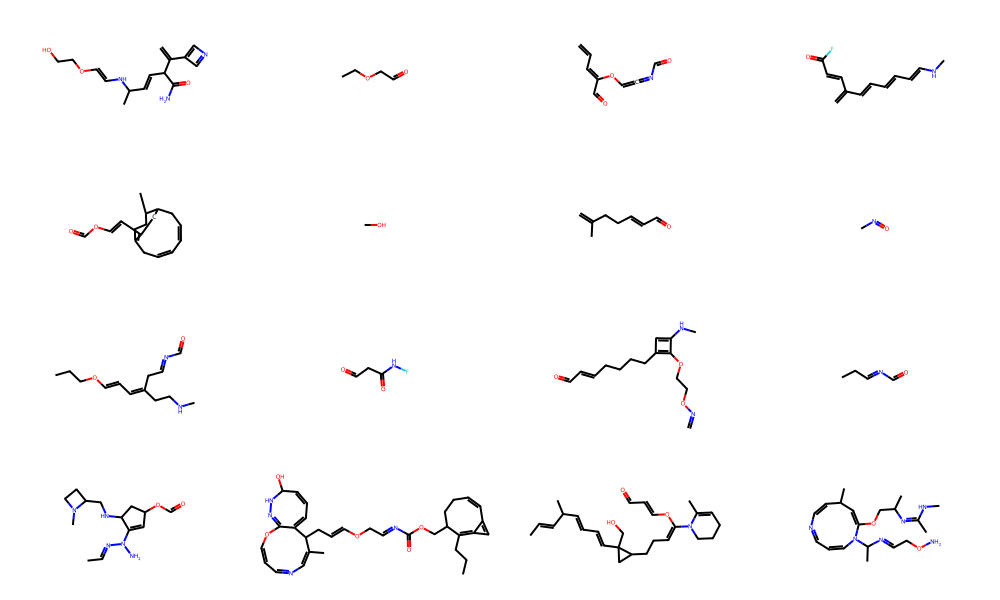

save model:  model_save/epoch_1.pt


epoch 2: 100%|██████████| 105/105 [00:26<00:00,  3.99it/s]


epoch 2, train_loss: 94.121
valid:  100.000 % | unique: 99.609 %


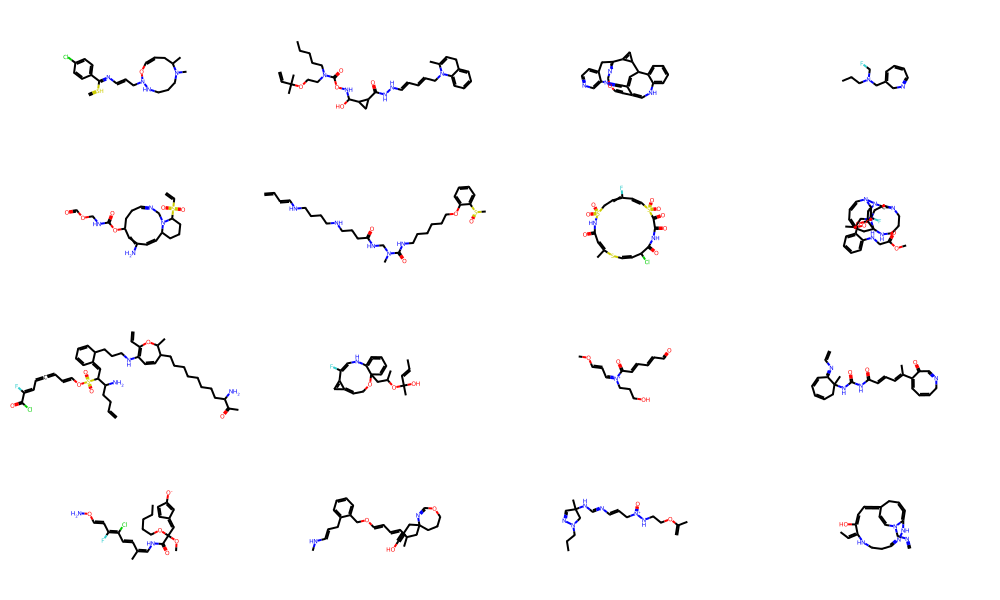

save model:  model_save/epoch_2.pt


epoch 3: 100%|██████████| 105/105 [00:26<00:00,  3.93it/s]


epoch 3, train_loss: 79.288
valid:  100.000 % | unique: 99.805 %


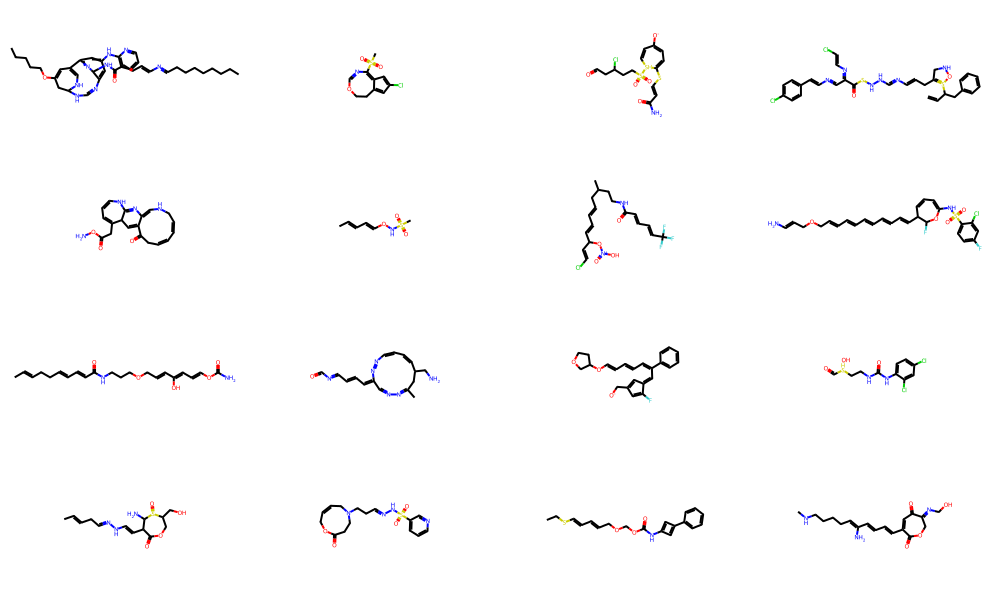

save model:  model_save/epoch_3.pt


epoch 4: 100%|██████████| 105/105 [00:27<00:00,  3.88it/s]


epoch 4, train_loss: 72.104
valid:  100.000 % | unique: 99.707 %


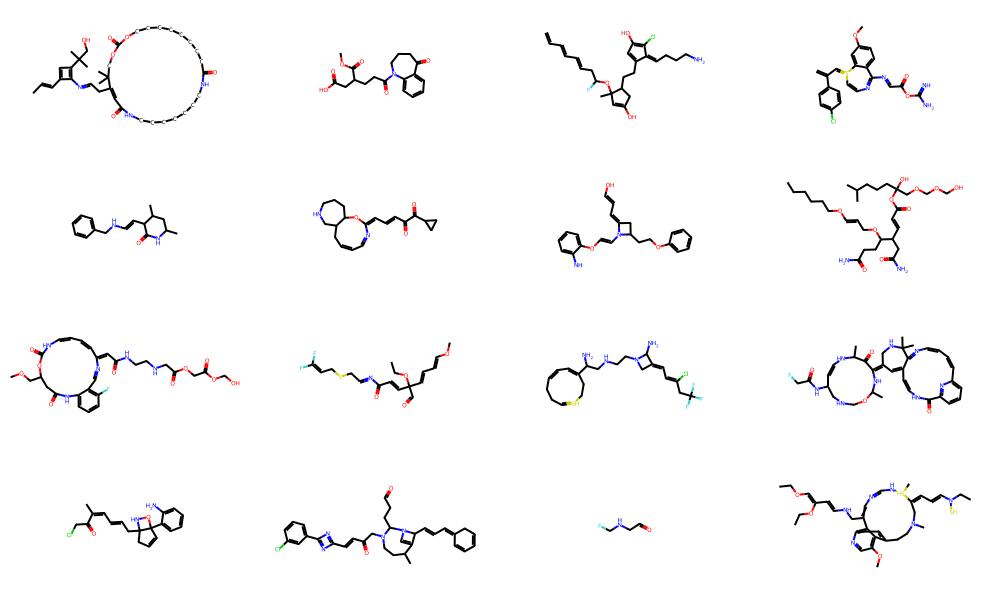

save model:  model_save/epoch_4.pt


epoch 5: 100%|██████████| 105/105 [00:27<00:00,  3.85it/s]


epoch 5, train_loss: 67.481
valid:  100.000 % | unique: 100.000 %


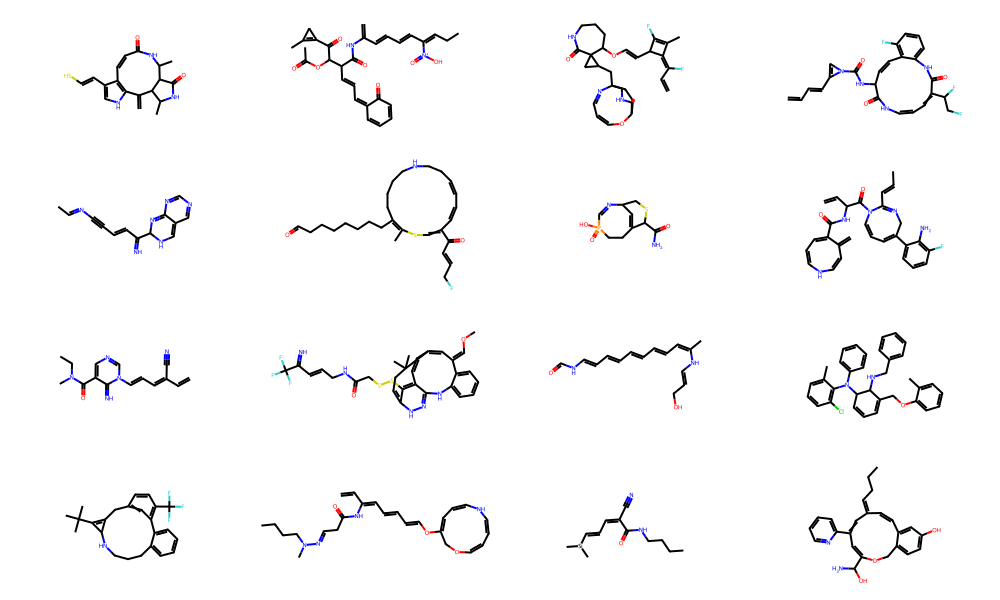

save model:  model_save/epoch_5.pt


epoch 6: 100%|██████████| 105/105 [00:27<00:00,  3.83it/s]


epoch 6, train_loss: 64.072
valid:  100.000 % | unique: 100.000 %


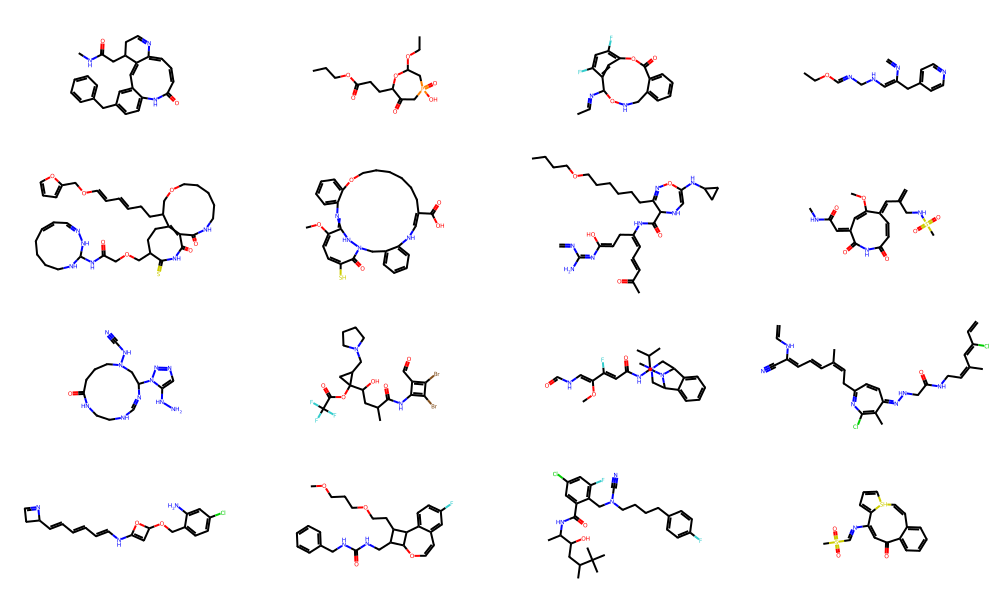

save model:  model_save/epoch_6.pt


epoch 7: 100%|██████████| 105/105 [00:27<00:00,  3.78it/s]


epoch 7, train_loss: 61.657
valid:  100.000 % | unique: 100.000 %


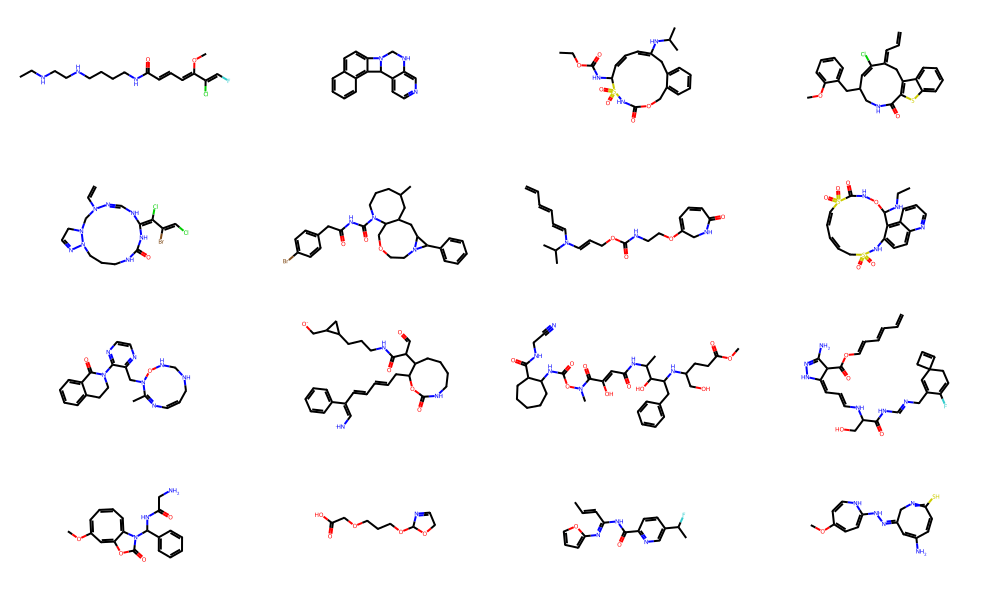

save model:  model_save/epoch_7.pt


epoch 8: 100%|██████████| 105/105 [00:27<00:00,  3.79it/s]


epoch 8, train_loss: 59.642
valid:  100.000 % | unique: 100.000 %


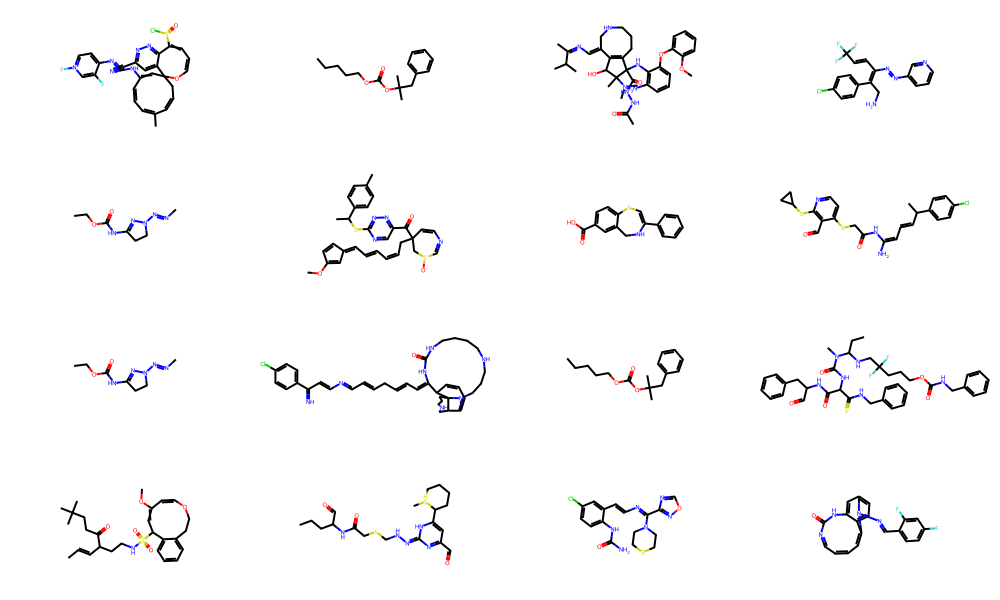

save model:  model_save/epoch_8.pt


epoch 9: 100%|██████████| 105/105 [00:27<00:00,  3.80it/s]


epoch 9, train_loss: 58.141
valid:  100.000 % | unique: 100.000 %


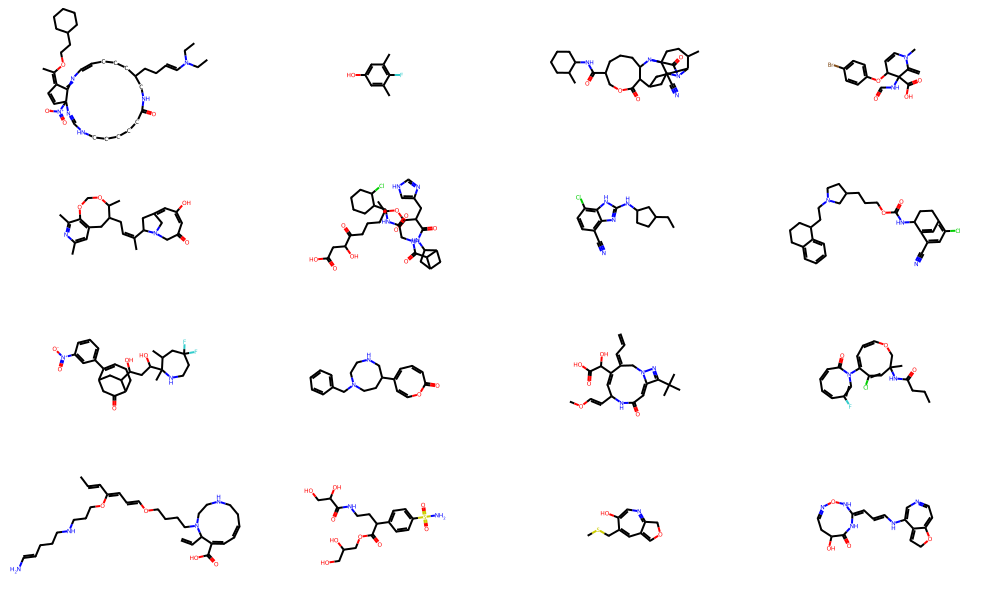

save model:  model_save/epoch_9.pt


epoch 10: 100%|██████████| 105/105 [00:27<00:00,  3.78it/s]


epoch 10, train_loss: 56.627
valid:  100.000 % | unique: 100.000 %


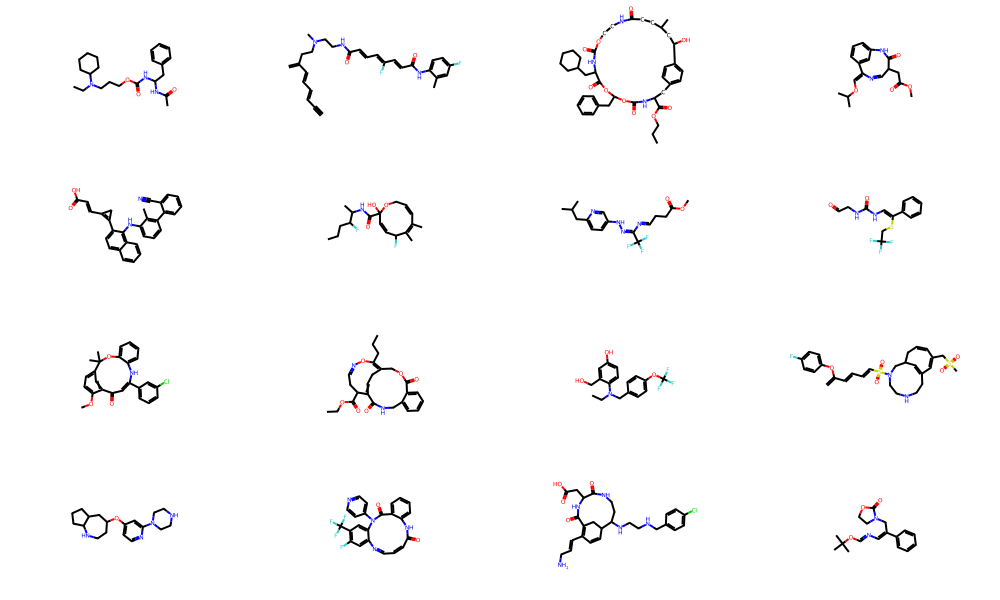

save model:  model_save/epoch_10.pt


In [35]:
if best_epoch != 0:
    load_model(model, out_dir + f'epoch_{best_epoch}.pt')

# device = 'cuda'

for epoch in range(1, 1+num_epoch):
    model.train()
    train_loss = 0
    for data, lengths in tqdm(dataloader, total=len(dataloader),
                              desc=f'epoch {epoch}'): # batch_size = 512
        # print(lengths)
        lengths = [l-1 for l in lengths]
        optimizer.zero_grad()
        if cuda: data = data.cuda()

        preds = model(data, lengths)

        targets = pack_padded_sequence(
            data[:, 1:], lengths, batch_first=True, enforce_sorted=False).data

        loss = loss_function(preds, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/train_size)
    print(f'epoch {epoch}, train_loss: {train_losses[-1]:.3f}')
    scheduler.step(train_losses[-1])
    sampled_molecules = sample(model, vocab, batch_size=1024)
    valid, unique = compute_valid_rate(sampled_molecules)
    print(f'valid:  {(valid * 100):.3f} % | unique: {(unique * 100):.3f} %')
    if valid > best_valid_rate:
        visual_mol(sampled_molecules)
        best_epoch = epoch
        trained_model_dir = out_dir + f'epoch_{epoch}.pt'
        print(f'save model: ', trained_model_dir)
        save_model(model, trained_model_dir)
        model_names.append(trained_model_dir)
        while len(model_names) > 10:
            try:
                remove_name = model_names.pop(0)
                print('remove ', remove_name)
                os.remove(remove_name)
            except: print(f'error remove {model_names[0]}')


  0%|          | 0/10 [00:00<?, ?it/s]

valid:  100.000 % | unique: 100.000 %


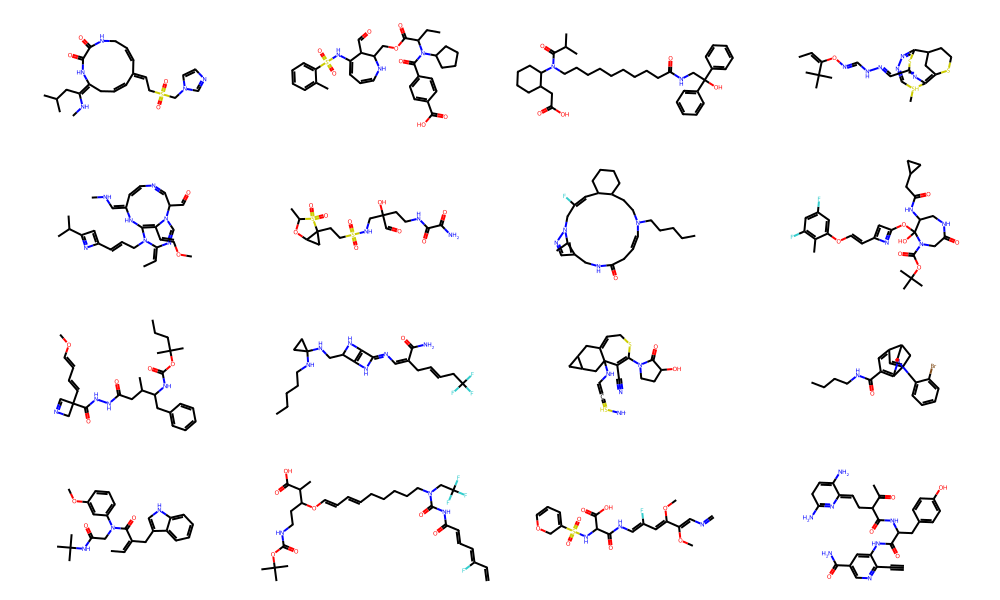

 10%|█         | 1/10 [00:00<00:05,  1.57it/s]

valid:  100.000 % | unique: 100.000 %


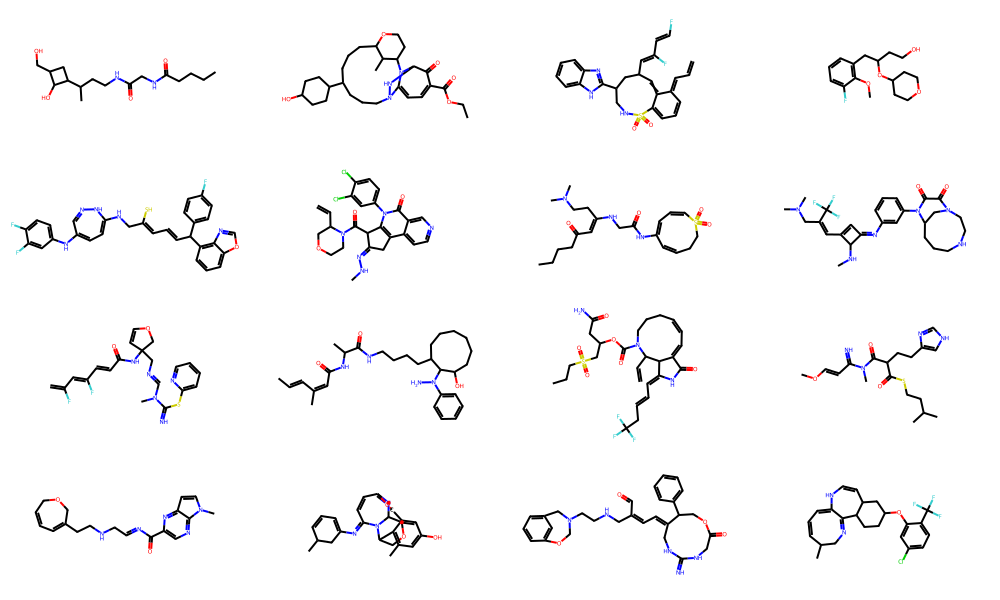

 20%|██        | 2/10 [00:01<00:04,  1.62it/s]

valid:  100.000 % | unique: 100.000 %


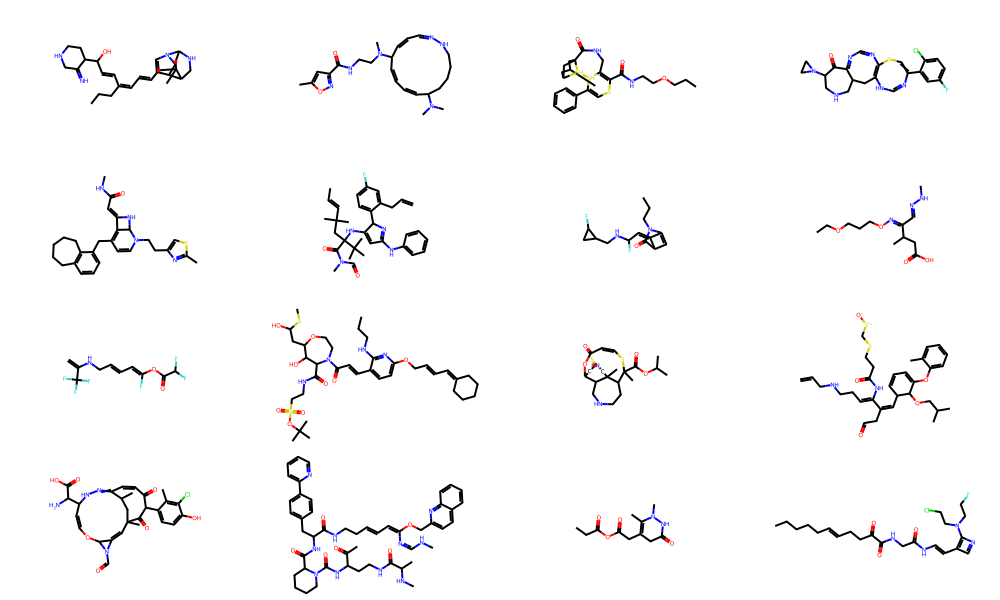

 30%|███       | 3/10 [00:01<00:04,  1.63it/s]

valid:  100.000 % | unique: 100.000 %


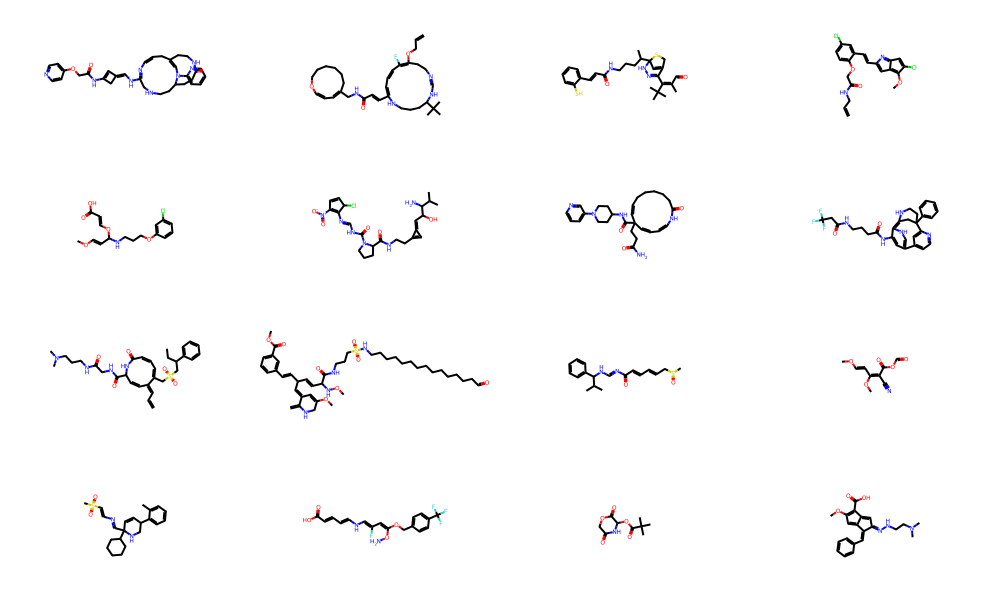

 40%|████      | 4/10 [00:02<00:03,  1.65it/s]

valid:  100.000 % | unique: 100.000 %


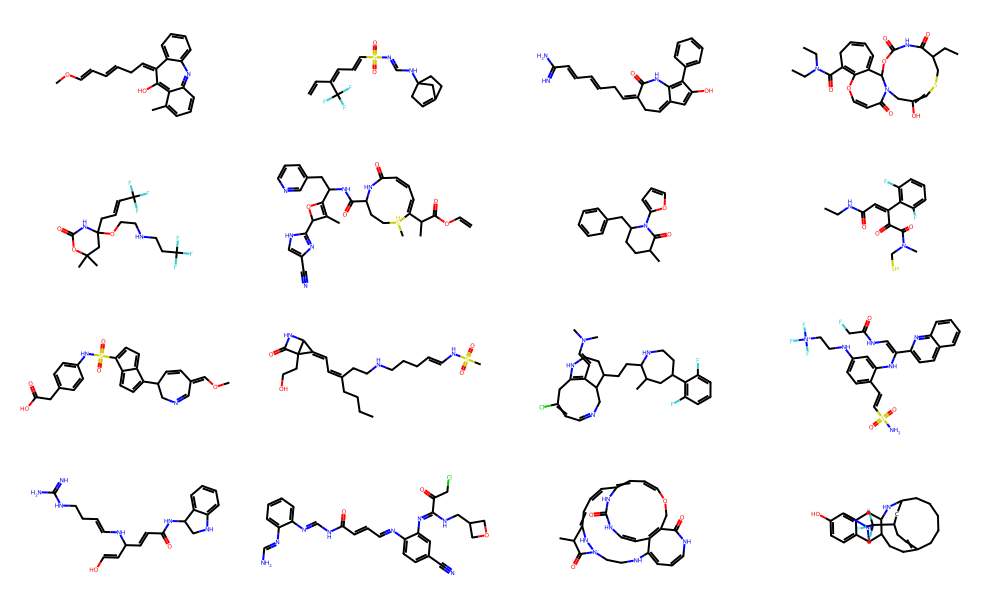

 50%|█████     | 5/10 [00:03<00:03,  1.64it/s]

valid:  100.000 % | unique: 100.000 %


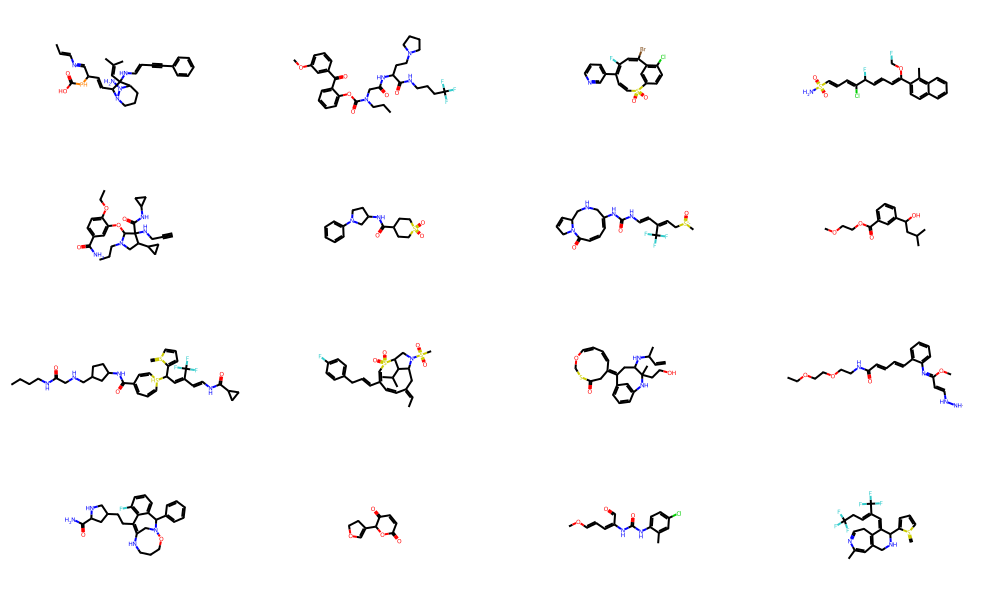

 60%|██████    | 6/10 [00:03<00:02,  1.62it/s]

valid:  100.000 % | unique: 100.000 %


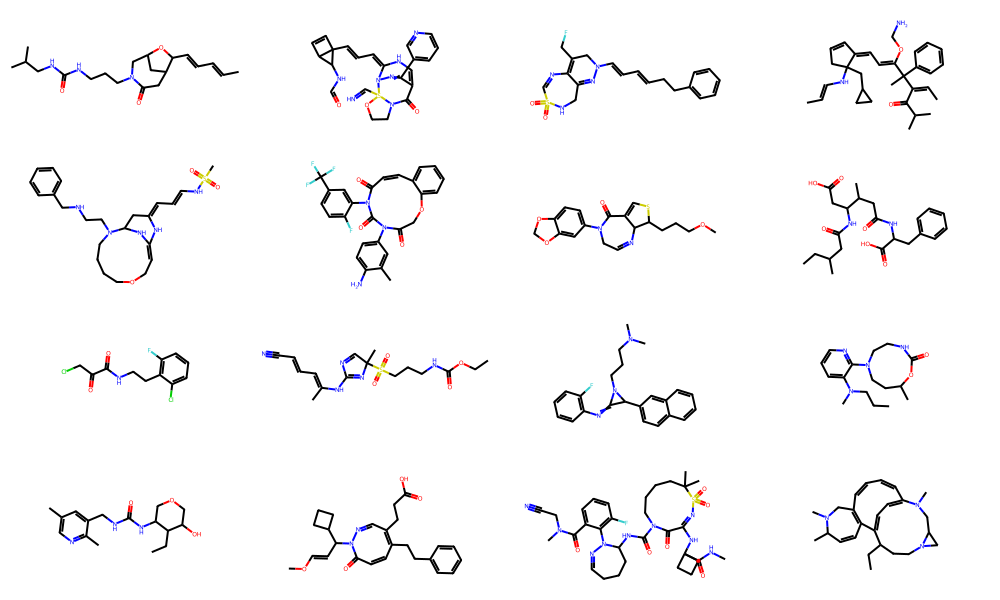

 70%|███████   | 7/10 [00:04<00:01,  1.62it/s]

valid:  100.000 % | unique: 100.000 %


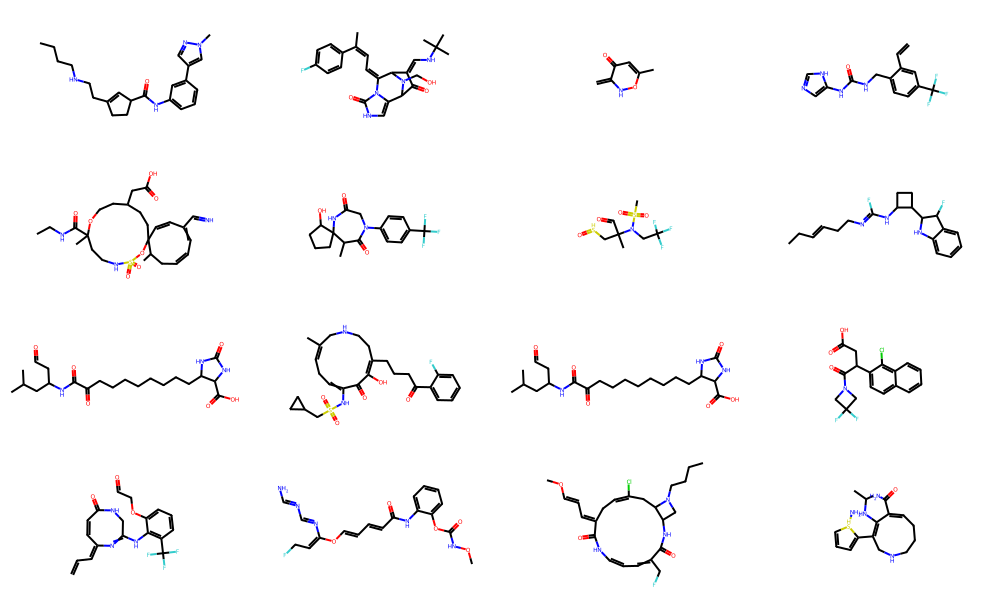

 80%|████████  | 8/10 [00:04<00:01,  1.62it/s]

valid:  100.000 % | unique: 100.000 %


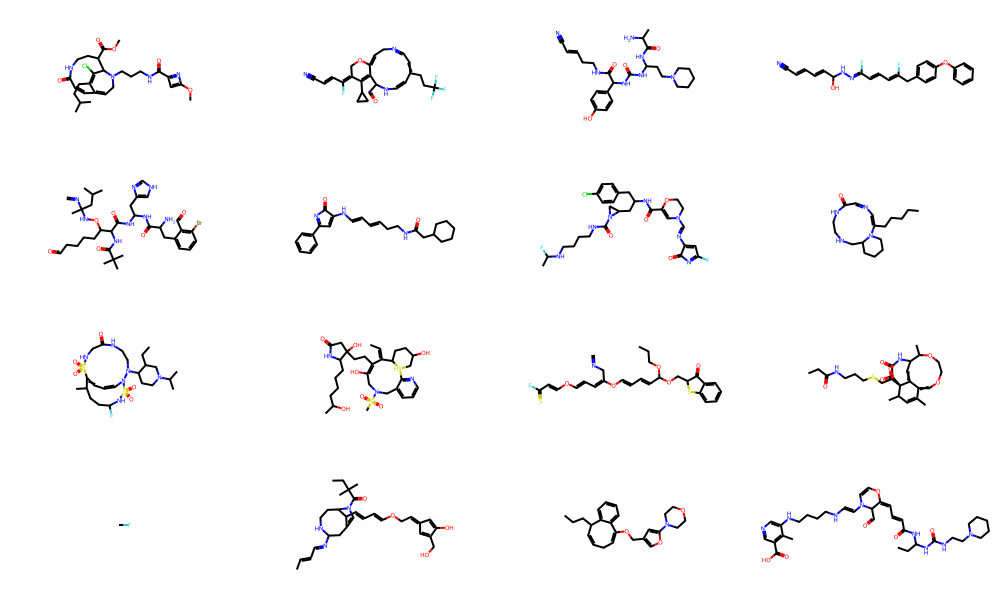

 90%|█████████ | 9/10 [00:05<00:00,  1.63it/s]

valid:  100.000 % | unique: 100.000 %


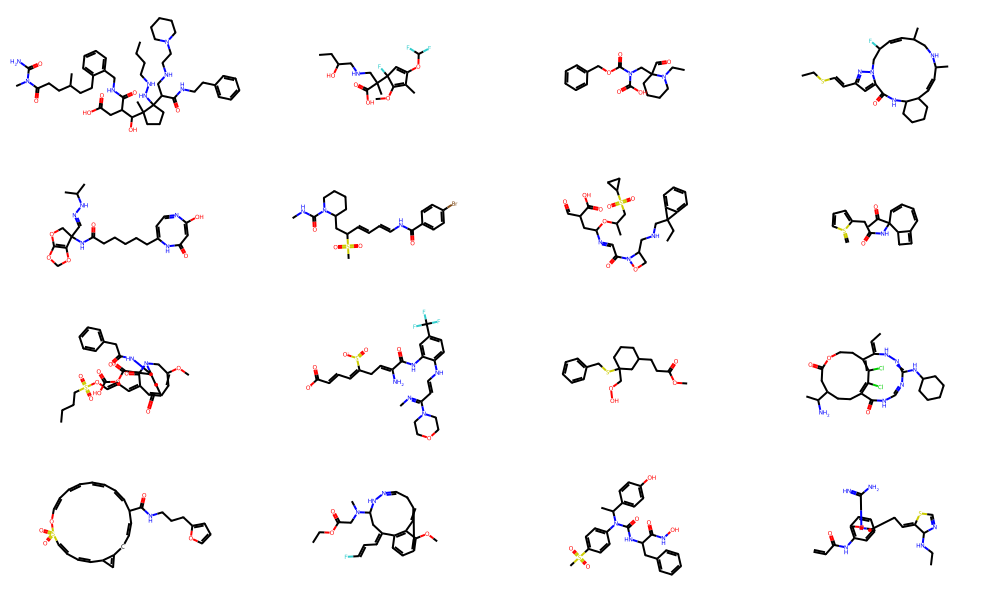

100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


In [36]:
best_dir = out_dir + f'epoch_{best_epoch}.pt'
with open(out_dir +'config.yaml', 'r') as f: config = yaml.full_load(f)
model = RNN(config).to(device)
load_model(model, best_dir)
model.eval()
num_batches = 10
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import random
import math
from rdkit import Chem
mol_conv = Chem.MolFromSmiles

for _ in tqdm(range(num_batches)):
    sampled_ints = model.sample(batch_size=batch_size,
                                vocab=vocab).tolist()
    mols = []
    for ints in sampled_ints:
        s_mol = []
        for x in ints:
            #######################################################
            if vocab.int2token[x] =='<eos>':break
            #######################################################

            else: s_mol.append(vocab.int2token[x])
        mols.append("".join(s_mol))
    mols = [sf.decoder(x) for x in mols]
    valid, unique = compute_valid_rate(mols)
    print(f'valid:  {(valid * 100):.3f} % | unique: {(unique * 100):.3f} %')
    all_correct_molecules = set(mols)
    MAX_GRID = 16
    show_num = min(len(all_correct_molecules), MAX_GRID)
    selected_smiles = random.choices([*all_correct_molecules], k=show_num)
    molecules = [mol_conv(i) for i in selected_smiles]

    img = MolsToGridImage(
        [m for m in molecules if m is not None],
        molsPerRow=int(math.sqrt(MAX_GRID)),
        subImgSize=(250, 150),  returnPNG=False)
    display(img)


The model has 4,064,846 trainable parameters


In [49]:
import copy
a = torch.randn([3,2])
b = a.copy()

AttributeError: ignored

0it [00:00, ?it/s]


RuntimeError: ignored

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
SELFIES: a robust representation of semantically constrained graphs with an
    example application in chemistry (https://arxiv.org/abs/1905.13741)
    by Mario Krenn, Florian Haese, AkshatKuman Nigam, Pascal Friederich,
    Alan Aspuru-Guzik.

    Variational Autoencoder (VAE) for chemistry
        comparing SMILES and SELFIES representation using reconstruction
        quality, diversity and latent space validity as metrics of
        interest

information:
    ML framework: pytorch
    chemistry framework: RDKit

    get_selfie_and_smiles_encodings_for_dataset
        generate complete encoding (inclusive alphabet) for SMILES and
        SELFIES given a data file

    VAEEncoder
        fully connected, 3 layer neural network - encodes a one-hot
        representation of molecule (in SMILES or SELFIES representation)
        to latent space

    VAEDecoder
        decodes point in latent space using an RNN

    latent_space_quality
        samples points from latent space, decodes them into molecules,
        calculates chemical validity (using RDKit's MolFromSmiles), calculates
        diversity
"""

import os
import sys
import time

import numpy as np
import pandas as pd
import torch
import yaml
from rdkit import rdBase
from rdkit.Chem import MolFromSmiles
from torch import nn
import selfies as sf


# from data_loader import \
#     multiple_selfies_to_hot, multiple_smile_to_hot

rdBase.DisableLog('rdApp.error')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""
This file is to encode SMILES and SELFIES into one-hot encodings
"""



import pandas as pd
from os import walk
import torch
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit import Chem
m = Chem.MolFromSmiles
import math


def smile_to_hot(smile, largest_smile_len, alphabet):
    """Go from a single smile string to a one-hot encoding.
    """

    char_to_int = dict((c, i) for i, c in enumerate(alphabet))

    # pad with ' '
    smile += ' ' * (largest_smile_len - len(smile))

    # integer encode input smile
    integer_encoded = [char_to_int[char] for char in smile]

    # one hot-encode input smile
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return integer_encoded, np.array(onehot_encoded)


def multiple_smile_to_hot(smiles_list, largest_molecule_len, alphabet):
    """Convert a list of smile strings to a one-hot encoding

    Returned shape (num_smiles x len_of_largest_smile x len_smile_encoding)
    """

    hot_list = []
    for s in smiles_list:
        _, onehot_encoded = smile_to_hot(s, largest_molecule_len, alphabet)
        hot_list.append(onehot_encoded)
    return np.array(hot_list)


def selfies_to_hot(selfie, largest_selfie_len, alphabet):
    """Go from a single selfies string to a one-hot encoding.
    """

    symbol_to_int = dict((c, i) for i, c in enumerate(alphabet))

    # pad with [nop]
    selfie += '[nop]' * (largest_selfie_len - sf.len_selfies(selfie))

    # integer encode
    symbol_list = sf.split_selfies(selfie)
    integer_encoded = [symbol_to_int[symbol] for symbol in symbol_list]

    # one hot-encode the integer encoded selfie
    onehot_encoded = list()
    for index in integer_encoded:
        letter = [0] * len(alphabet)
        letter[index] = 1
        onehot_encoded.append(letter)

    return integer_encoded, np.array(onehot_encoded)


def multiple_selfies_to_hot(selfies_list, largest_molecule_len, alphabet):
    """Convert a list of selfies strings to a one-hot encoding
    """

    hot_list = []
    for s in selfies_list:
        _, onehot_encoded = selfies_to_hot(s, largest_molecule_len, alphabet)
        hot_list.append(onehot_encoded)
    return np.array(hot_list)

def _make_dir(directory):
    os.makedirs(directory)


def save_models(encoder, decoder, epoch):
    out_dir = './saved_models/{}'.format(epoch)
    _make_dir(out_dir)
    torch.save(encoder, '{}/E'.format(out_dir))
    torch.save(decoder, '{}/D'.format(out_dir))


class VAEEncoder(nn.Module):

    def __init__(self, in_dimension, layer_1d, layer_2d, layer_3d,
                 latent_dimension):
        """
        Fully Connected layers to encode molecule to latent space
        """
        super(VAEEncoder, self).__init__()
        self.latent_dimension = latent_dimension

        # Reduce dimension up to second last layer of Encoder
        self.encode_nn = nn.Sequential(
            nn.Linear(in_dimension, layer_1d),
            nn.ReLU(),
            nn.Linear(layer_1d, layer_2d),
            nn.ReLU(),
            nn.Linear(layer_2d, layer_3d),
            nn.ReLU()
        )

        # Latent space mean
        self.encode_mu = nn.Linear(layer_3d, latent_dimension)

        # Latent space variance
        self.encode_log_var = nn.Linear(layer_3d, latent_dimension)

    @staticmethod
    def reparameterize(mu, log_var):
        """
        This trick is explained well here:
            https://stats.stackexchange.com/a/16338
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        """
        Pass throught the Encoder
        """
        # Get results of encoder network
        h1 = self.encode_nn(x)

        # latent space
        mu = self.encode_mu(h1)
        log_var = self.encode_log_var(h1)

        # Reparameterize
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var


class VAEDecoder(nn.Module):

    def __init__(self, latent_dimension, gru_stack_size, gru_neurons_num,
                 out_dimension):
        """
        Through Decoder
        """
        super(VAEDecoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.gru_stack_size = gru_stack_size
        self.gru_neurons_num = gru_neurons_num

        # Simple Decoder
        self.decode_RNN = nn.GRU(
            input_size=latent_dimension,
            hidden_size=gru_neurons_num,
            num_layers=gru_stack_size,
            batch_first=False)

        self.decode_FC = nn.Sequential(
            nn.Linear(gru_neurons_num, out_dimension),
        )

    def init_hidden(self, batch_size=1):
        weight = next(self.parameters())
        return weight.new_zeros(self.gru_stack_size, batch_size,
                                self.gru_neurons_num)

    def forward(self, z, hidden):
        """
        A forward pass throught the entire model.
        """

        # Decode
        l1, hidden = self.decode_RNN(z, hidden)
        decoded = self.decode_FC(l1)  # fully connected layer

        return decoded, hidden


def is_correct_smiles(smiles):
    """
    Using RDKit to calculate whether molecule is syntactically and
    semantically valid.
    """
    if smiles == "":
        return False

    try:
        return MolFromSmiles(smiles, sanitize=True) is not None
    except Exception:
        return False


def sample_latent_space(vae_encoder, vae_decoder, sample_len):
    vae_encoder.eval()
    vae_decoder.eval()

    gathered_atoms = []

    fancy_latent_point = torch.randn(1, 1, vae_encoder.latent_dimension,
                                     device=device)
    hidden = vae_decoder.init_hidden()

    # runs over letters from molecules (len=size of largest molecule)
    for _ in range(sample_len):
        out_one_hot, hidden = vae_decoder(fancy_latent_point, hidden)

        out_one_hot = out_one_hot.flatten().detach()
        soft = nn.Softmax(0)
        out_one_hot = soft(out_one_hot)

        out_index = out_one_hot.argmax(0)
        gathered_atoms.append(out_index.data.cpu().tolist())

    vae_encoder.train()
    vae_decoder.train()

    return gathered_atoms

import random
import math
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit import Chem
mol_conv = Chem.MolFromSmiles

def latent_space_quality(vae_encoder, vae_decoder, type_of_encoding,
                         alphabet, sample_num, sample_len, epoch):
    total_correct = 0
    all_correct_molecules = set()
    print(f"latent_space_quality:"
          f" Take {sample_num} samples from the latent space")

    for _ in tqdm(range(1, sample_num + 1), total=sample_num):

        molecule_pre = ''
        for i in sample_latent_space(vae_encoder, vae_decoder, sample_len):
            molecule_pre += alphabet[i]
        molecule = molecule_pre.replace(' ', '')

        if type_of_encoding == 1:  # if SELFIES, decode to SMILES
            molecule = sf.decoder(molecule)

        if is_correct_smiles(molecule):
            total_correct += 1
            all_correct_molecules.add(molecule)

    MAX_GRID = 16
    show_num = min(len(all_correct_molecules), MAX_GRID)
    selected_smiles = random.choices([*all_correct_molecules], k=show_num)
    molecules = [mol_conv(i) for i in selected_smiles]

    img = MolsToGridImage(
        [m for m in molecules if m is not None],
        molsPerRow=int(math.sqrt(MAX_GRID)),
        subImgSize=(250, 150),  returnPNG=False
        # legends=legends,
    )
    display(img)
    import os
    if not os.path.exists('figs/'): os.makedirs('figs/')
    img.save(f'figs/latent_sample_{epoch}.png')
    print('figure saved at :', 'figs/', f'latent_sample_{epoch}.png')

    return total_correct, len(all_correct_molecules)


def quality_in_valid_set(vae_encoder, vae_decoder, data_valid, batch_size):
    data_valid = data_valid[torch.randperm(data_valid.size()[0])]  # shuffle
    num_batches_valid = len(data_valid) // batch_size

    quality_list = []
    for batch_iteration in range(min(25, num_batches_valid)):

        # get batch
        start_idx = batch_iteration * batch_size
        stop_idx = (batch_iteration + 1) * batch_size
        batch = data_valid[start_idx: stop_idx]
        _, trg_len, _ = batch.size()

        inp_flat_one_hot = batch.flatten(start_dim=1)
        latent_points, mus, log_vars = vae_encoder(inp_flat_one_hot)

        latent_points = latent_points.unsqueeze(0)
        hidden = vae_decoder.init_hidden(batch_size=batch_size)
        out_one_hot = torch.zeros_like(batch, device=device)
        for seq_index in range(trg_len):
            out_one_hot_line, hidden = vae_decoder(latent_points, hidden)
            out_one_hot[:, seq_index, :] = out_one_hot_line[0]

        # assess reconstruction quality
        quality = compute_recon_quality(batch, out_one_hot)
        quality_list.append(quality)

    return np.mean(quality_list).item()


def compute_elbo(x, x_hat, mus, log_vars, KLD_alpha):
    inp = x_hat.reshape(-1, x_hat.shape[2])
    target = x.reshape(-1, x.shape[2]).argmax(1)

    criterion = torch.nn.CrossEntropyLoss()
    recon_loss = criterion(inp, target)
    kld = -0.5 * torch.mean(1. + log_vars - mus.pow(2) - log_vars.exp())

    return recon_loss + KLD_alpha * kld, recon_loss, kld


import shutil
def train_model(vae_encoder, vae_decoder,
                data_train, data_valid, num_epochs, batch_size,
                lr_enc, lr_dec, weight_decay_enc,weight_decay_dec, KLD_alpha,
                sample_num, sample_len, alphabet, type_of_encoding):
    """
    Train the Variational Auto-Encoder
    """

    print('num_epochs: ', num_epochs)

    # initialize an instance of the model
    optimizer_encoder = torch.optim.AdamW(vae_encoder.parameters(), lr=lr_enc, weight_decay=weight_decay_enc)
    optimizer_decoder = torch.optim.AdamW(vae_decoder.parameters(), lr=lr_dec, weight_decay=weight_decay_dec)

    data_train = data_train.clone().detach().to(device)
    num_batches_train = int(len(data_train) / batch_size)

    quality_valid_list = [0, 0, 0, 0]
    folder_names = []
    for epoch in range(num_epochs):

        data_train = data_train[torch.randperm(data_train.size()[0])]

        start = time.time()
        LOSS, BCE, KLD = 0, 0, 0
        for batch_iteration in range(num_batches_train):  # batch iterator

            # manual batch iterations
            start_idx = batch_iteration * batch_size
            stop_idx = (batch_iteration + 1) * batch_size
            batch = data_train[start_idx: stop_idx]

            # reshaping for efficient parallelization
            inp_flat_one_hot = batch.flatten(start_dim=1)
            latent_points, mus, log_vars = vae_encoder(inp_flat_one_hot)

            # initialization hidden internal state of RNN (RNN has two inputs
            # and two outputs:)
            #    input: latent space & hidden state
            #    output: one-hot encoding of one character of molecule & hidden
            #    state the hidden state acts as the internal memory
            latent_points = latent_points.unsqueeze(0)
            hidden = vae_decoder.init_hidden(batch_size=batch_size)

            # decoding from RNN N times, where N is the length of the largest
            # molecule (all molecules are padded)
            out_one_hot = torch.zeros_like(batch, device=device)
            for seq_index in range(batch.shape[1]):
                out_one_hot_line, hidden = vae_decoder(latent_points, hidden)
                out_one_hot[:, seq_index, :] = out_one_hot_line[0]

            # compute ELBO
            loss, bce, kld = compute_elbo(batch, out_one_hot,
                                          mus, log_vars, KLD_alpha)

            # perform back propogation
            optimizer_encoder.zero_grad()
            optimizer_decoder.zero_grad()
            loss.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(vae_decoder.parameters(), 0.5)
            optimizer_encoder.step()
            optimizer_decoder.step()
            LOSS += loss.item()
            BCE += bce.item()
            KLD += kld.item()

            if (batch_iteration+1) % int(num_batches_train/3) == 0:
                end = time.time()

                # assess reconstruction quality
                quality_train = compute_recon_quality(batch, out_one_hot)
                quality_valid = quality_in_valid_set(vae_encoder, vae_decoder,
                                                     data_valid, batch_size)

                report = 'Epoch: %d,  Batch: %d / %d, (loss: %.3f | ' \
                         'quality: %.3f | quality_val: %.3f)   ' \
                         'ELAPSED TIME: %.5f' \
                         % (epoch, batch_iteration, num_batches_train,
                            loss.item(), quality_train, quality_valid,
                            end - start)
                print(report)
                start = time.time()
        print(f'[TRAIN] LOSS: {LOSS:.3f}, BCE: {BCE:.3f}, KLD: {KLD:.3f}',
              f'KLD/LOSS: {(KLD/LOSS * 100):.3f} %')
        quality_valid = quality_in_valid_set(vae_encoder, vae_decoder,
                                             data_valid, batch_size)
        quality_valid_list.append(quality_valid)

        # only measure validity of reconstruction improved
        quality_increase = len(quality_valid_list) \
                           - np.argmax(quality_valid_list)
        if quality_increase == 1 and quality_valid_list[-1] > 50.:
            corr, unique = latent_space_quality(vae_encoder, vae_decoder,
                                                type_of_encoding, alphabet,
                                                sample_num, sample_len, epoch)

            model_path = f'vae/epoch_{epoch}/'
            if not os.path.exists(model_path): os.makedirs(model_path)
            folder_names.append(model_path)
            torch.save(vae_encoder.state_dict(), model_path+'enc.pt')
            torch.save(vae_decoder.state_dict(), model_path+'dec.pt')
            while len(folder_names) > 10:
                try:
                    remove_dir_name = folder_names.pop(0)
                    print('remove dir: ', remove_dir_name)
                    # os.rmdir(remove_dir_name) # cannot delete non empty dir

                    shutil.rmtree(remove_dir_name, ignore_errors=True)
                except:
                    print(f'error when delete {folder_names[0]}')
        else:
            corr, unique = -1., -1.

        report = 'Validity: %.3f %% | Diversity: %.3f %% | ' \
                 'Reconstruction: %.3f %%' \
                 % (corr * 100. / sample_num, unique * 100. / sample_num,
                    quality_valid)
        print(report)

        with open('results.dat', 'a') as content:
            content.write(report + '\n')

        if quality_valid_list[-1] < 70. and epoch > 200:
            break

        if quality_increase > 20:
            print('Early stopping criteria')
            break



def compute_recon_quality(x, x_hat):
    x_indices = x.reshape(-1, x.shape[2]).argmax(1)
    x_hat_indices = x_hat.reshape(-1, x_hat.shape[2]).argmax(1)

    differences = 1. - torch.abs(x_hat_indices - x_indices)
    differences = torch.clamp(differences, min=0., max=1.).double()
    quality = 100. * torch.mean(differences)
    quality = quality.detach().cpu().numpy()

    return quality


def get_selfie_and_smiles_encodings_for_dataset(file_path_or_df):
    """
    Returns encoding, alphabet and length of largest molecule in SMILES and
    SELFIES, given a file containing SMILES molecules.

    input:
        csv file with molecules. Column's name must be 'smiles'.
    output:
        - selfies encoding
        - selfies alphabet
        - longest selfies string
        - smiles encoding (equivalent to file content)
        - smiles alphabet (character based)
        - longest smiles string
    """
    if isinstance(file_path_or_df, str):
        file_path = file_path_or_df
        df = pd.read_csv(file_path)
    else: df = file_path_or_df

    smiles_list = np.asanyarray(df.smiles)

    smiles_alphabet = list(set(''.join(smiles_list)))
    smiles_alphabet.append(' ')  # for padding

    largest_smiles_len = len(max(smiles_list, key=len))

    print('--> Translating SMILES to SELFIES...')
    selfies_list = list(map(sf.encoder, smiles_list))

    all_selfies_symbols = sf.get_alphabet_from_selfies(selfies_list)
    all_selfies_symbols.add('[nop]')
    selfies_alphabet = list(all_selfies_symbols)

    largest_selfies_len = max(sf.len_selfies(s) for s in selfies_list)

    print(f'Finished translating {len(selfies_list)} SMILES to SELFIES.')

    return selfies_list, selfies_alphabet, largest_selfies_len, \
           smiles_list, smiles_alphabet, largest_smiles_len


def main(file_name_smiles, type_of_encoding, dynamic_z_dim=False):
    content = open('logfile.dat', 'w')
    content.close()
    content = open('results.dat', 'w')
    content.close()

    if os.path.exists("settings.yml"):
        settings = yaml.safe_load(open("settings.yml", "r"))
    else:
        print("Expected a file settings.yml but didn't find it.")
        return

    print('--> Acquiring data...')
    # type_of_encoding = settings['data']['type_of_encoding']
    # file_name_smiles = settings['data']['smiles_file']

    print('Finished acquiring data.')

    if type_of_encoding == 0:
        print('Representation: SMILES')
        print('There are :', len(file_name_smiles), ' compounds')
        _, _, _, encoding_list, encoding_alphabet, largest_molecule_len = \
            get_selfie_and_smiles_encodings_for_dataset(file_name_smiles)

        print('--> Creating one-hot encoding...')
        data = multiple_smile_to_hot(encoding_list, largest_molecule_len,
                                     encoding_alphabet)
        print('Finished creating one-hot encoding.')

    elif type_of_encoding == 1:
        print('Representation: SELFIES')
        encoding_list, encoding_alphabet, largest_molecule_len, _, _, _ = \
            get_selfie_and_smiles_encodings_for_dataset(file_name_smiles)

        print('--> Creating one-hot encoding...')
        data = multiple_selfies_to_hot(encoding_list, largest_molecule_len,
                                       encoding_alphabet)
        print('Finished creating one-hot encoding.')

    else:
        print("type_of_encoding not in {0, 1}.")
        return
    len_compound = data.shape[0]
    len_max_molec = data.shape[1]
    len_alphabet = data.shape[2]
    len_max_mol_one_hot = len_max_molec * len_alphabet

    print(' ')
    print(f"Dataset has {len_compound} compounds, "
          f"Alphabet has {len_alphabet} letters, "
          f"largest molecule is {len_max_molec} letters.")

    data_parameters = settings['data']
    batch_size = data_parameters['batch_size']

    if dynamic_z_dim:
        z_dim = int(len_max_mol_one_hot/300)*100
        settings['encoder']['latent_dimension'] = z_dim
        settings['decoder']['latent_dimension'] = z_dim
        print(f'z_dim {z_dim} is set to ~ 1/3 of in_dim {len_max_mol_one_hot}')
    print(settings['encoder'])
    encoder_parameter = settings['encoder']
    decoder_parameter = settings['decoder']
    training_parameters = settings['training']

    vae_encoder = VAEEncoder(in_dimension=len_max_mol_one_hot,
                             **encoder_parameter).to(device)
    vae_decoder = VAEDecoder(**decoder_parameter,
                             out_dimension=len(encoding_alphabet)).to(device)

    print('*' * 15, ': -->', device)

    data = torch.tensor(data, dtype=torch.float).to(device)

    train_valid_test_size = [0.5, 0.5, 0.0]
    data = data[torch.randperm(data.size()[0])]
    idx_train_val = int(len(data) * train_valid_test_size[0])
    idx_val_test = idx_train_val + int(len(data) * train_valid_test_size[1])

    data_train = data[0:idx_train_val]
    data_valid = data[idx_train_val:idx_val_test]

    print("start training")
    train_model(**training_parameters,
                vae_encoder=vae_encoder,
                vae_decoder=vae_decoder,
                batch_size=batch_size,
                data_train=data_train,
                data_valid=data_valid,
                alphabet=encoding_alphabet,
                type_of_encoding=type_of_encoding,
                sample_len=len_max_molec)

    with open('COMPLETED', 'w') as content:
        content.write('exit code: 0')


# if __name__ == '__main__':
#     try:
#         main()
#     except AttributeError:
#         _, error_message, _ = sys.exc_info()
#         print(error_message)

In [11]:
smiles_df = jak_data.Smiles






In [23]:
import selfies as sf

valid_sfs = []
for smi in tqdm(smiles_df, total=len(smiles_df)):
    try:
        drug_sf = sf.encoder(smi)
        drug_smi = sf.decoder(drug_sf)
        valid_sfs.append(drug_sf)
    except sf.EncoderError: pass
    except sf.DecoderError: pass


100%|██████████| 25739/25739 [00:26<00:00, 982.15it/s]


In [24]:
selfies_df = pd.DataFrame(valid_sfs, columns=['Selfies'])
selfies_df.to_csv('/content/drive/MyDrive/A_DATA/jak_selfies.csv', index=False)

In [25]:
len(selfies_df)

25739

In [26]:
dataset = list(selfies_df)

In [27]:
selfies_df

,Selfies
0,[2H][C][Branch1][C][2H][Branch1][C][2H][N][=C]...
1,[2H][C][Branch1][C][2H][Branch1][C][2H][N][C][...
2,[2H][C][Branch1][C][2H][Branch1][C][2H][N][C][...
3,[2H][C][Branch1][C][2H][Branch1][C][2H][N][C][...
4,[2H][C][Branch1][C][2H][Branch1][C][2H][N][C][...
...,...
25734,[O][C][=N][C][=C][C][C][=Branch2][Ring1][=Bran...
25735,[O][C][C][=C][C][=C][Branch1][C][F][C][=C][Rin...
25736,[O][C][C][=C][C][=C][Branch1][C][F][C][=C][Rin...
25737,[O][N][=C][Branch1][C][O][C][C][C][C][C][C][N]...


In [30]:

if isinstance(selfies_df, pd.DataFrame): dataset = selfies_df['Selfies'].tolist()
else: dataset = selfies_df # dataset type: list

alphabet = sf.get_alphabet_from_selfies(dataset)
alphabet.add("[nop]")
alphabet.add('.')
alphabet = list(sorted(alphabet))
print('len alphabet: ', len(alphabet))
__t2i_sf = {s: i for i, s in enumerate(alphabet)}









len alphabet:  59


In [31]:
import torch

max_len_in_dataset = max(sf.len_selfies(s) for s in dataset)
max_len = 120
print('max len in dataset:', max_len_in_dataset)
if max_len < max_len_in_dataset:
    print(f'current defined max len: {max_len} < {max_len_in_dataset}, Abort')
else:
    labels = []
    one_hots = []
    for selfi in tqdm(dataset, total=len(dataset)):
        label, one_hot = sf.selfies_to_encoding(selfies = selfi,
                vocab_stoi = __t2i_sf, pad_to_len = max_len, enc_type='both')
        labels.append(label)
        one_hots.append(one_hot)
    label = torch.Tensor(label)
    one_hot = torch.Tensor(one_hot)



max len in dataset: 109


In [51]:
labels = []
one_hots = []
for selfi in tqdm(dataset, total=len(dataset)):
    label, one_hot = sf.selfies_to_encoding(selfies = selfi,
            vocab_stoi = __t2i_sf, pad_to_len = max_len, enc_type='both')
    labels.append(label)
    one_hots.append(one_hot)
labels = torch.Tensor(labels).long()
one_hots = torch.Tensor(one_hots).long()
dict_ = {'labels': labels,
         'one_hots': one_hots,
         'alphabet': alphabet}
torch.save(dict_, '/content/drive/MyDrive/A_DATA/jak_selfies_dataset.pt')
# labels.shape, one_hots.shape

100%|██████████| 25739/25739 [00:09<00:00, 2786.20it/s]


In [38]:
import torch

torch.Tensor(one_hot).shape

torch.Size([120, 59])

In [48]:
torch.save(dict_, '/content/drive/MyDrive/A_DATA/jak_selfies_dataset.pt')

In [49]:
d = torch.load('/content/drive/MyDrive/A_DATA/jak_selfies_dataset.pt')


In [55]:
name ='/content/drive/MyDrive/A_DATA/jak_selfies_dataset.pt'
name.split('.')[-1] == 'pt'

True

In [52]:
labels.shape, one_hots.shape

(torch.Size([25739, 120]), torch.Size([25739, 120, 59]))

In [53]:
type(alphabet)

list

In [23]:
cd /content

/content


In [24]:
!rm -R 'a_inhibitor_design'
! git clone https://github.com/yingzibu/a_inhibitor_design.git

Cloning into 'a_inhibitor_design'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 99 (delta 26), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (99/99), 34.63 KiB | 4.95 MiB/s, done.
Resolving deltas: 100% (26/26), done.


a_inhibitor_design/  drive/  sample_data/


In [25]:
cd a_inhibitor_design/data

/content/a_inhibitor_design/data


data/  model/  README.md


In [83]:
ls

chembl_smi_len.png  README.md  tokenizer.py  tokenizer_selfies.py


In [26]:
from tokenizer_selfies import SmilesToSelfies as ss
from tokenizer_selfies import SelfiesToDataset as sd

In [13]:
sdf = ss(smiles_df)

100%|██████████| 25739/25739 [00:25<00:00, 1024.97it/s]


In [91]:
from tokenizer_selfies import SelfiesToDataset as sdd


NameError: ignored

In [14]:
from tokenizer_selfies import SelfiesToDataset

In [27]:
dict_ = sd(sdf, max_len=120, savename='test.pt')

len alphabet:  59
max len in dataset: 109


100%|██████████| 25739/25739 [00:08<00:00, 3102.38it/s]


dataset saved at: test.pt


In [94]:
ls

chembl_smi_len.png  README.md  tokenizer.py  tokenizer_selfies.py


In [113]:
from tokenizer_selfies import dummy

ImportError: ignored